In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("../data/spots_1.csv", usecols=[2,4,5,7])
df.head(10)

,TRACK_ID,POSITION_X,POSITION_Y,POSITION_T
0,2,214.349,258.314,0
1,0,266.836,125.367,0
2,1,288.871,145.176,0
3,1,293.075,147.088,1
4,2,217.941,259.736,1
5,0,266.813,125.370,1
6,0,266.859,125.372,2
7,1,297.551,149.068,2
8,2,221.416,260.945,2
9,0,266.873,125.349,3


In [16]:
spots = df.values
print("Numer of spots:", len(spots)/3)

Numer of spots: 6361.0


In [14]:
origin = []
top = []
bottom = []

for spot in spots:
    spot_coord = [spot[1], spot[2]]
    if spot[0] == 0:
        origin.append(spot_coord)
    elif spot[0] == 2:
        top.append(spot_coord)
    else:
        bottom.append(spot_coord)
        
origin, top, bottom = np.array(origin), np.array(top), np.array(bottom)

0.3079394242396769 0.0012593209737327415 -1.5989696376336702 -0.018075437726941312


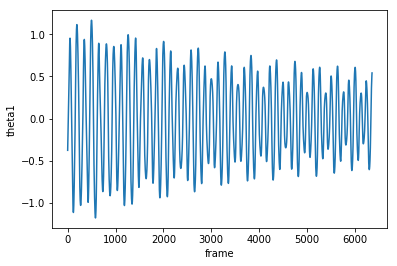

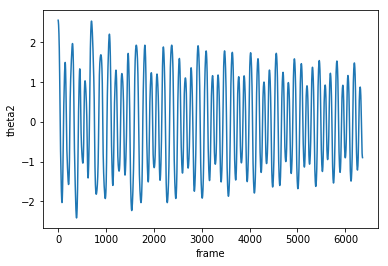

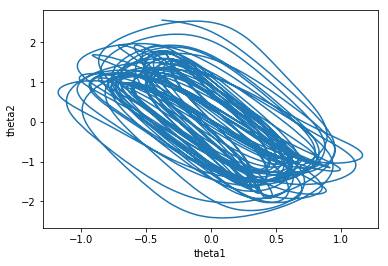

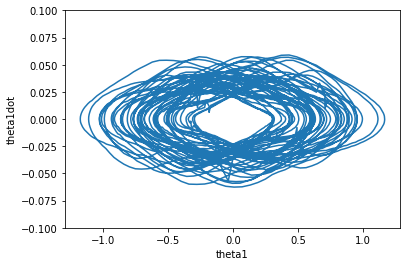

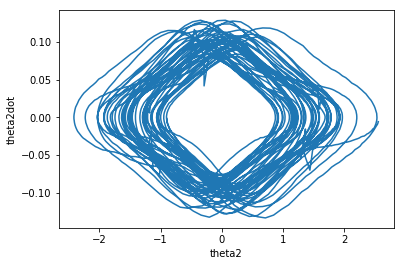

In [20]:
def coord2angle(x):
    slope = x[0] / x[1]
    base = np.arctan(slope)
    if x[0] >= 0 and x[1] >= 0:
        angle = base
    elif x[0] >= 0 and x[1] < 0:
        angle = base + np.pi
    elif x[0] < 0 and x[1] >= 0:
        angle = base
    else:
        angle = base - np.pi
    return angle

top_norm = top - origin
bottom_norm = bottom - top
theta1 = [coord2angle(coord) for coord in top_norm]
theta2 = [coord2angle(coord) for coord in bottom_norm]
theta1p = np.gradient(theta1)
theta2p = np.gradient(theta2)

a = 0
b = -1
plt.figure()
plt.xlabel("frame")
plt.ylabel("theta1")
plt.plot(theta1[a:b])

plt.figure()
plt.xlabel("frame")
plt.ylabel("theta2")
plt.plot(theta2[a:b])

plt.figure()
plt.xlabel("theta1")
plt.ylabel("theta2")
plt.plot(theta1[a:b], theta2[a:b])

plt.figure()
plt.ylim(-0.1,0.1)
plt.xlabel("theta1")
plt.ylabel("theta1dot")
plt.plot(theta1[a:b], theta1p[a:b])

plt.figure()
plt.xlabel("theta2")
plt.ylabel("theta2dot")
plt.plot(theta2[a:b], theta2p[a:b])

init = 5000
print(theta1[init], theta1p[init], theta2[init], theta2p[init])